# 1. Load the stereo Image

In [5]:
pip install opencv-python

In [6]:
import cv2
import numpy as np


# Load stereo images
left_image = cv2.imread('/content/im13_l.bmp')
right_image = cv2.imread('/content/im13_r.bmp')


# 1.1 Convet to HSV domain

In [7]:
# Convert the images from RGB to HSV format
left_image = cv2.cvtColor(left_image, cv2.COLOR_RGB2HSV)
right_image = cv2.cvtColor(right_image, cv2.COLOR_RGB2HSV)
left_image.shape

(360, 640, 3)

# 2. Calculate the Image Gradients

In [8]:
# Function to compute gradients for a color image
def compute_gradients(image):
    # Compute x and y gradients for each color channel
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    return grad_x, grad_y

# Compute gradients for the left image
grad_x_left, grad_y_left = compute_gradients(left_image)

# Compute gradients for the right image
grad_x_right, grad_y_right = compute_gradients(right_image)


# 3. Compute the Difference Image (z-Direction Gradient)

In [9]:
# Compute the difference (z-gradient) between the left and right images for each channel
diff_z = left_image.astype(np.float64) - right_image.astype(np.float64)


# 4. Form the Extended Structure Tensor

In [10]:
# Initialize tensor components
S11 = np.zeros(left_image.shape[:2])  # Sum of I_{ix}^2 for all channels
S12 = np.zeros(left_image.shape[:2])  # Sum of I_{ix} * I_{iy} for all channels
S13 = np.zeros(left_image.shape[:2])  # Sum of I_{ix} * I_{iz} for all channels
S22 = np.zeros(left_image.shape[:2])  # Sum of I_{iy}^2 for all channels
S23 = np.zeros(left_image.shape[:2])  # Sum of I_{iy} * I_{iz} for all channels
S33 = np.zeros(left_image.shape[:2])  # Sum of I_{iz}^2 for all channels

# Compute the sums for each pixel
for i in range(3):  # Iterate over each color channel (RGB)
    S11 += grad_x_left[:, :, i] ** 2
    S12 += grad_x_left[:, :, i] * grad_y_left[:, :, i]
    S13 += grad_x_left[:, :, i] * diff_z[:, :, i]
    S22 += grad_y_left[:, :, i] ** 2
    S23 += grad_y_left[:, :, i] * diff_z[:, :, i]
    S33 += diff_z[:, :, i] ** 2


# 5. Calculate Eigenvalues and Eigenvectors

In [11]:
# Function to compute the largest eigenvector of a 3x3 matrix at each pixel
def compute_disparity_map(S11, S12, S13, S22, S23, S33):
    # Create an empty disparity map
    disparity_map = np.zeros(left_image.shape[:2])

    # Iterate over each pixel to compute eigenvalues and eigenvectors
    for x in range(left_image.shape[0]):
        for y in range(left_image.shape[1]):
            # Construct the matrix S at each pixel
            S = np.array([[S11[x, y], S12[x, y], S13[x, y]],
                          [S12[x, y], S22[x, y], S23[x, y]],
                          [S13[x, y], S23[x, y], S33[x, y]]])

            # Compute eigenvalues and eigenvectors
            eigenvalues, eigenvectors = np.linalg.eigh(S)

            # Find the largest eigenvalue and corresponding eigenvector
            largest_eigenvalue_index = np.argmax(eigenvalues)
            largest_eigenvector = eigenvectors[:, largest_eigenvalue_index]

            # Use the largest eigenvector to compute the disparity value
            # (Here we use its magnitude as a simple proxy for disparity; other methods can be applied)
            disparity_map[x, y] = np.linalg.norm(largest_eigenvector)

    return disparity_map

# Compute the disparity map
disparity_map = compute_disparity_map(S11, S12, S13, S22, S23, S33)
disparity_map.shape


(360, 640)

# 6. Visualize the Disparity Map

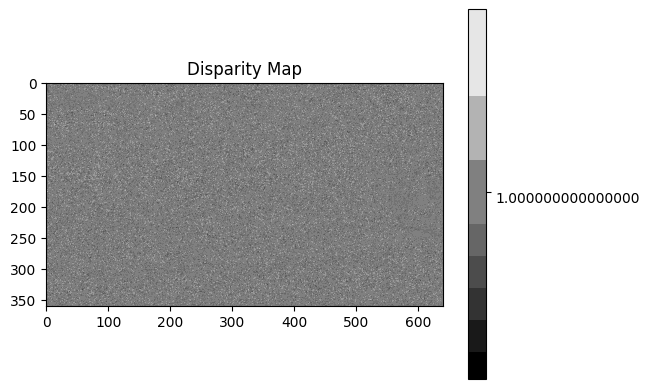

In [12]:
import matplotlib.pyplot as plt

# Display the disparity map
plt.imshow(disparity_map, cmap='gray')
plt.colorbar()
plt.title('Disparity Map')
plt.show()


# 7. Cyclopean Image Creation

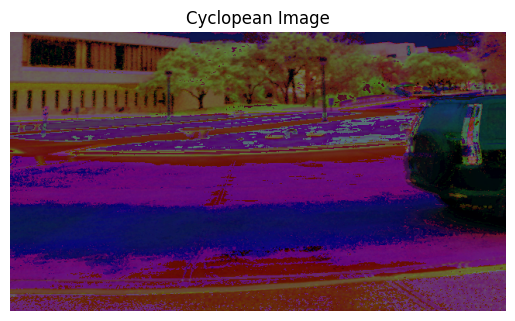

In [13]:
def create_cyclopean_image(left_image, right_image, disparity_map, window_size= 9):
    """
    Create a cyclopean image from the left and right stereo images using the disparity map.

    Parameters:
    - left_image: The left stereo image (RGB).
    - right_image: The right stereo image (RGB).
    - disparity_map: The disparity map computed from the left and right images.
    - window_size: The size of the local window to use for averaging (default is 3).

    Returns:
    - cyclopean_image: The resulting cyclopean image.
    """
    # Get the image dimensions
    height, width, channels = left_image.shape

    # Initialize the cyclopean image
    cyclopean_image = np.zeros_like(left_image, dtype=np.float64)

    # Define half window size for extracting local patches
    half_window = window_size // 2

    # Loop over each pixel in the left image
    for x in range(half_window, height - half_window):
        for y in range(half_window, width - half_window):
            # Get disparity value for the current pixel (rounded to the nearest integer)
            disparity = int(disparity_map[x, y])

            # Ensure the shifted index is within the image boundaries
            right_y = min(max(y - disparity, half_window), width - half_window - 1)

            # Extract local patches from both images
            left_patch = left_image[x - half_window:x + half_window + 1, y - half_window:y + half_window + 1, :]
            right_patch = right_image[x - half_window:x + half_window + 1, right_y - half_window:right_y + half_window + 1, :]

            # Compute the average of the two patches to form the cyclopean image
            cyclopean_patch = (left_patch + right_patch)//2

            # Place the averaged patch into the cyclopean image
            cyclopean_image[x - half_window:x + half_window + 1, y - half_window:y + half_window + 1, :] = cyclopean_patch


    # Clip values to valid range [0, 255] for image representation
    cyclopean_image = np.clip(cyclopean_image, 0, 255).astype(np.uint8)

    return cyclopean_image

# Create the cyclopean image
cyclopean_image = create_cyclopean_image(left_image, right_image, disparity_map)

# Plot the cyclopean image
plt.imshow(cyclopean_image)
plt.title('Cyclopean Image')
plt.axis('off')
plt.show()
